#### BERT Sequence Classifier Reference Blogpost 
https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
!pip install -U torch==1.9.0

In [2]:
!pip install transformers

In [3]:
!pip install pickle5

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig

from transformers import AdamW, get_linear_schedule_with_warmup
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle5 as pkl
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

In [5]:
train_dataset_path = "tos_clauses_train.csv"
test_dataset_path = "tos_clauses_dev.csv"
train_df = pd.read_csv(train_dataset_path, header=0)
test_df = pd.read_csv(test_dataset_path, header=0)

In [6]:
def read_embeddings():
    train_avg_embeddings_file_path = "train_roberta_avg_embeddings.pkl"
    with open(train_avg_embeddings_file_path, mode="rb") as train_file:
        train_data = pkl.load(train_file) 
    test_avg_embeddings_file_path = "test_roberta_avg_embeddings.pkl"
    with open(test_avg_embeddings_file_path, mode="rb") as test_file:
        test_data = pkl.load(test_file) 
    return train_data, test_data

train_data, test_data = read_embeddings()


In [7]:
df_train = pd.DataFrame(train_data)
df_train["embeddings"] = df_train.values.tolist()
df_train = df_train[["embeddings"]]
df_train["label"] = train_df["label"]

In [8]:
df_test = pd.DataFrame(test_data)
df_test["embeddings"] = df_test.values.tolist()
df_test = df_test[["embeddings"]]
df_test["label"] = test_df["label"]
df_test.head(1)

,embeddings,label
0,"[0.12160861492156982, 0.15411289036273956, -0....",0


In [9]:
class TensorDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.array(self.data.loc[index, 'embeddings'])
        label = int(self.data.loc[index, 'label'])
        return torch.from_numpy(features).float(), label
    
    def __getindexlist__(self):
        return list(self.data.index.values)

work_train = df_train.copy()
work_test = df_test.copy()
X_train_tensor = TensorDataset(work_train)
X_test_tensor = TensorDataset(work_test)

num_of_workers = 0
batch_size = 20
valid_size = 0.2

num_train = len(X_train_tensor)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx))
print(len(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_of_workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_of_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, 
    num_workers=num_of_workers, drop_last=True)

6025
1506


In [10]:
train_df_by_index = work_train.loc[train_idx]
val_df_by_index = work_train.loc[valid_idx]
train_fair = sum(train_df_by_index['label'] == 0)
train_unfair = sum(train_df_by_index['label'] == 1)
val_fair = sum(val_df_by_index['label'] == 0)
val_unfair = sum(val_df_by_index['label'] == 1)

print("train_fair:" + str(train_fair))
print("train_unfair:" + str(train_unfair))
print("val_fair:" + str(val_fair))
print("val_unfair:" + str(val_unfair))

train_fair:5342
train_unfair:683
val_fair:1363
val_unfair:143


In [11]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

params = list(model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
    
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

epochs = 4
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [14]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs, train_idx, val_idx):
    epoch_nums_list = []
    train_loss_list = []
    val_loss_list = []
    model.train()
    criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([1/train_fair, 1/train_unfair]))
    for epoch_num in range(epochs):
        print("Epoch: " + str(epoch_num))
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            model.zero_grad()
            train_input = torch.reshape(train_input, (20, 1, 768))
            output = model(inputs_embeds = train_input, labels = train_label.long())
            logits = output[1]
            loss = criterion(logits, train_label.long())
            total_loss_train += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            logits = logits.detach().numpy()
            acc = flat_accuracy(logits, train_label.numpy())
            total_acc_train += acc
            
            
            optimizer.step()
            scheduler.step()
            
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_input = torch.reshape(val_input, (20, 1, 768))
                output = model(inputs_embeds = val_input, labels = val_label.long())
                logits = output[1]
                loss = criterion(logits, val_label.long())
                total_loss_val += loss.item()
                    
                
                logits = logits.detach().numpy()
                acc = flat_accuracy(logits, val_label.numpy())
                total_acc_val += acc
            
        print(
                f'Epochs: {epoch_num} | Train Loss: {total_loss_train / len(train_idx): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
                | Val Loss: {total_loss_val / len(val_idx): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')
        epoch_nums_list.append(epoch_num)
        train_loss_list.append(1- (total_acc_train / len(train_dataloader)))
        val_loss_list.append(1- (total_acc_val / len(val_dataloader)))
        
        if epoch_num in [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80]:
            torch.save(model.state_dict(), "roberta_avg_models/" + "rmod_" + str(epoch_num) + "_file.pt")
    return epoch_nums_list, train_loss_list, val_loss_list
EPOCHS = 80
LR = 1e-3
              
epoch_nums_list, train_loss_list, val_loss_list = train(model, train_loader, valid_loader, LR, EPOCHS, train_idx, valid_idx)

  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 0


100%|█████████████████████████████████████████| 301/301 [01:16<00:00,  3.93it/s]


Epochs: 0 | Train Loss:  0.035                 | Train Accuracy:  0.811                 | Val Loss:  0.034                 | Val Accuracy:  0.903


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 1


100%|█████████████████████████████████████████| 301/301 [01:19<00:00,  3.77it/s]


Epochs: 1 | Train Loss:  0.035                 | Train Accuracy:  0.819                 | Val Loss:  0.034                 | Val Accuracy:  0.763


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 2


100%|█████████████████████████████████████████| 301/301 [01:20<00:00,  3.74it/s]


Epochs: 2 | Train Loss:  0.035                 | Train Accuracy:  0.753                 | Val Loss:  0.034                 | Val Accuracy:  0.904


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 3


100%|█████████████████████████████████████████| 301/301 [01:23<00:00,  3.59it/s]


Epochs: 3 | Train Loss:  0.035                 | Train Accuracy:  0.808                 | Val Loss:  0.034                 | Val Accuracy:  0.877


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 4


100%|█████████████████████████████████████████| 301/301 [01:21<00:00,  3.72it/s]


Epochs: 4 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.889


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 5


100%|█████████████████████████████████████████| 301/301 [01:19<00:00,  3.79it/s]


Epochs: 5 | Train Loss:  0.034                 | Train Accuracy:  0.860                 | Val Loss:  0.034                 | Val Accuracy:  0.879


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 6


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 6 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.875
Epoch: 7


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.884
Epoch: 8


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 8 | Train Loss:  0.034                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.884
Epoch: 9


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 9 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 10


100%|█████████████████████████████████████████| 301/301 [01:13<00:00,  4.07it/s]


Epochs: 10 | Train Loss:  0.034                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.882


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 11


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 11 | Train Loss:  0.035                 | Train Accuracy:  0.856                 | Val Loss:  0.034                 | Val Accuracy:  0.887
Epoch: 12


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 12 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 13


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 13 | Train Loss:  0.035                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.882
Epoch: 14


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 14 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 15


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 15 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 16


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 16 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 17


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 17 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 18


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 18 | Train Loss:  0.035                 | Train Accuracy:  0.858                 | Val Loss:  0.034                 | Val Accuracy:  0.882
Epoch: 19


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 19 | Train Loss:  0.035                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 20


100%|█████████████████████████████████████████| 301/301 [01:14<00:00,  4.06it/s]


Epochs: 20 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.871


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 21


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 21 | Train Loss:  0.034                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.887
Epoch: 22


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 22 | Train Loss:  0.035                 | Train Accuracy:  0.859                 | Val Loss:  0.034                 | Val Accuracy:  0.876
Epoch: 23


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 23 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 24


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 24 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.887
Epoch: 25


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 25 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.886
Epoch: 26


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 26 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.882
Epoch: 27


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 27 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.884
Epoch: 28


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 28 | Train Loss:  0.034                 | Train Accuracy:  0.860                 | Val Loss:  0.034                 | Val Accuracy:  0.887
Epoch: 29


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 29 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.871
Epoch: 30


100%|█████████████████████████████████████████| 301/301 [01:16<00:00,  3.91it/s]


Epochs: 30 | Train Loss:  0.035                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.882


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 31


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 31 | Train Loss:  0.034                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 32


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 32 | Train Loss:  0.034                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.880
Epoch: 33


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 33 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.880
Epoch: 34


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 34 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.873
Epoch: 35


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 35 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.878
Epoch: 36


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 36 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.885
Epoch: 37


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 37 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 38


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 38 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.876
Epoch: 39


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 39 | Train Loss:  0.035                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.880
Epoch: 40


100%|█████████████████████████████████████████| 301/301 [01:18<00:00,  3.83it/s]


Epochs: 40 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.880


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 41


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 41 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.888
Epoch: 42


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 42 | Train Loss:  0.034                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 43


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 43 | Train Loss:  0.035                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.875
Epoch: 44


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 44 | Train Loss:  0.035                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.874
Epoch: 45


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 45 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.875
Epoch: 46


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 46 | Train Loss:  0.034                 | Train Accuracy:  0.858                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 47


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 47 | Train Loss:  0.035                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.874
Epoch: 48


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 48 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 49


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 49 | Train Loss:  0.034                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 50


100%|█████████████████████████████████████████| 301/301 [01:17<00:00,  3.88it/s]


Epochs: 50 | Train Loss:  0.034                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.875


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 51


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 51 | Train Loss:  0.035                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.873
Epoch: 52


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 52 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.878
Epoch: 53


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 53 | Train Loss:  0.035                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.873
Epoch: 54


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 54 | Train Loss:  0.034                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 55


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 55 | Train Loss:  0.035                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.874
Epoch: 56


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 56 | Train Loss:  0.034                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 57


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 57 | Train Loss:  0.034                 | Train Accuracy:  0.857                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 58


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 58 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.884
Epoch: 59


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 59 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 60


100%|█████████████████████████████████████████| 301/301 [01:19<00:00,  3.81it/s]


Epochs: 60 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.881


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 61


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 61 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.870
Epoch: 62


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 62 | Train Loss:  0.035                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.886
Epoch: 63


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 63 | Train Loss:  0.034                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.885
Epoch: 64


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 64 | Train Loss:  0.035                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 65


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 65 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 66


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 66 | Train Loss:  0.035                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 67


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 67 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 68


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 68 | Train Loss:  0.035                 | Train Accuracy:  0.861                 | Val Loss:  0.034                 | Val Accuracy:  0.884
Epoch: 69


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 69 | Train Loss:  0.034                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.881
Epoch: 70


100%|█████████████████████████████████████████| 301/301 [01:22<00:00,  3.63it/s]


Epochs: 70 | Train Loss:  0.034                 | Train Accuracy:  0.860                 | Val Loss:  0.034                 | Val Accuracy:  0.881


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epoch: 71


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 71 | Train Loss:  0.035                 | Train Accuracy:  0.862                 | Val Loss:  0.034                 | Val Accuracy:  0.883
Epoch: 72


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 72 | Train Loss:  0.035                 | Train Accuracy:  0.860                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 73


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 73 | Train Loss:  0.034                 | Train Accuracy:  0.864                 | Val Loss:  0.034                 | Val Accuracy:  0.875
Epoch: 74


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 74 | Train Loss:  0.034                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.875
Epoch: 75


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 75 | Train Loss:  0.034                 | Train Accuracy:  0.867                 | Val Loss:  0.034                 | Val Accuracy:  0.877
Epoch: 76


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 76 | Train Loss:  0.035                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.882
Epoch: 77


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 77 | Train Loss:  0.035                 | Train Accuracy:  0.866                 | Val Loss:  0.034                 | Val Accuracy:  0.882
Epoch: 78


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Epochs: 78 | Train Loss:  0.035                 | Train Accuracy:  0.865                 | Val Loss:  0.034                 | Val Accuracy:  0.879
Epoch: 79


100%|█████████████████████████████████████████| 301/301 [01:21<00:00,  3.69it/s]


Epochs: 79 | Train Loss:  0.035                 | Train Accuracy:  0.863                 | Val Loss:  0.034                 | Val Accuracy:  0.884


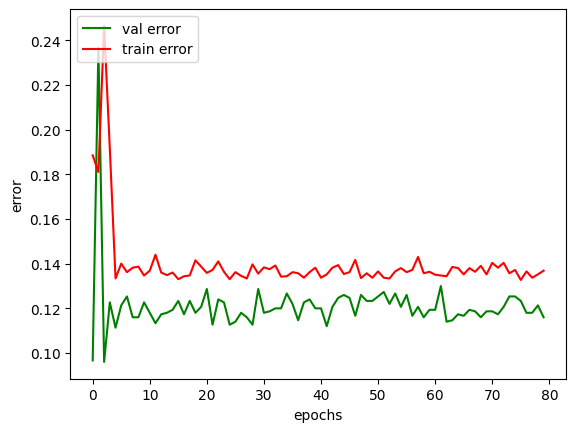

In [15]:
plt.plot(epoch_nums_list, val_loss_list, color = 'green', label = 'val error')
plt.plot(epoch_nums_list, train_loss_list, color = 'red', label = 'train error')
plt.legend(loc = 'upper left')
plt.ylabel('error')
plt.xlabel('epochs')
plt.show()

In [16]:
def evaluate(model, test_dataloader, test_data):
    prediction_list = []
    actual_list = []
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_input = torch.reshape(test_input, (len(test_data), 1, 768))
            output = model(inputs_embeds = test_input)
            logits = output[0]
            logits = logits.detach().numpy()
            acc = flat_accuracy(logits, test_label.numpy())
            total_acc_test += acc
            
            prediction_list.append(logits.argmax(axis=1))
            actual_list.append(test_label)
    
    print(f'Test Accuracy: {total_acc_test / len(test_dataloader): .3f}')
    
    return prediction_list[0].tolist(), actual_list[0].tolist()

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
prediction_list, actual_list = evaluate(model, test_loader, df_test)
report = classification_report(actual_list, prediction_list, output_dict=True)
report

Test Accuracy:  0.874


{'0': {'precision': 0.8930131004366813,
  'recall': 0.975551580202743,
  'f1-score': 0.932459390139641,
  'support': 1677},
 '1': {'precision': 0.19607843137254902,
  'recall': 0.04854368932038835,
  'f1-score': 0.07782101167315175,
  'support': 206},
 'accuracy': 0.8741370154009559,
 'macro avg': {'precision': 0.5445457659046151,
  'recall': 0.5120476347615657,
  'f1-score': 0.5051402009063963,
  'support': 1883},
 'weighted avg': {'precision': 0.8167685216649281,
  'recall': 0.8741370154009559,
  'f1-score': 0.8389620423095312,
  'support': 1883}}

In [17]:
from tabulate import tabulate
import os 

def evaluate(test_dataloader, test_data):
    path = "roberta_avg_models/"
    files = os.listdir("./roberta_avg_models/")
    files.sort()
    for file in files:
        print("Model Epoch: " + file)
        curr_model = RobertaForSequenceClassification.from_pretrained(
            "roberta-base",
            num_labels = 2,
            output_attentions = False,
            output_hidden_states = False,)
        curr_model.load_state_dict(torch.load(path + file))
        prediction_list = []
        actual_list = []
        total_acc_test = 0
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_input = torch.reshape(test_input, (len(test_data), 1, 768))
                output = curr_model(inputs_embeds = test_input)
                logits = output[0]
                logits = logits.detach().numpy()
                acc = flat_accuracy(logits, test_label.numpy())
                total_acc_test += acc
            
                prediction_list.append(logits.argmax(axis=1))
                actual_list.append(test_label)
    
        print(f'Test Accuracy: {total_acc_test / len(test_dataloader): .3f}')
        report = classification_report(actual_list[0].tolist(), prediction_list[0].tolist())
        print(report)

test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=len(df_test), num_workers=num_of_workers, drop_last=True)
evaluate(test_loader, df_test)

Model Epoch: rmod_0_file.pt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_10_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_1_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_20_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_2_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_30_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_3_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_40_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_4_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_50_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_5_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_60_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883

Model Epoch: rmod_70_file.pt


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Test Accuracy:  0.891
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1677
           1       0.00      0.00      0.00       206

    accuracy                           0.89      1883
   macro avg       0.45      0.50      0.47      1883
weighted avg       0.79      0.89      0.84      1883



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa